### set seed so that the model outputs are reproducible
After the kernel is restarted the same results are created.

In [1]:
import keras
import tensorflow as tf
from tensorflow.keras import initializers
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(0)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

## Load the data

In [2]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from time import sleep
from tqdm import tqdm
import warnings


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])



### Drop features that contain missing values

In [3]:
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


data = features_df_list[-1]['data']
if 'gleditsch_ward' in data.columns:
    data = data.drop(columns='gleditsch_ward') # column not necessary

## Features without missing values
columns_without_missing_values = data.columns[data.notna().all()]

for i in range(len(features_df_list)):
    data_set = features_df_list[i]['data']
    features_df_list[i]['data'] = data_set[columns_without_missing_values]

all_features = features_df_list[-1]['data'].columns


### Group data by country_id

In [4]:
country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

## Länder aussortieren
die nicht gefordert sind und
*  die keine actuals haben
*  die zu wenig Beobachtungen haben

In [5]:
relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV-Datei einlesen und als Pandas-Datensatz speichern
countryList_prediction = pd.read_csv(path_countrylist)
country_list_views = countryList_prediction.loc[:,'country_id'].values.tolist() 

month_list = []
countries_to_remove = []
for country_id in country_list:

    if country_id in country_list_views:
        feature_data = country_feature_group_list[0].get_group(country_id)

        # numbers of months from the feature dataset
        month_list_feature_data_original = feature_data.index.get_level_values('month_id').tolist()
        number_months_feature_data = len(month_list_feature_data_original) 

        if check_Actuals(country_id, 0):
            if not check_last_featureMonth(country_id, 0): 
                month_list.append([str(country_id) +' last month missing'])
            else:
                month_list.append([number_months_feature_data, country_id])
        else:
            month_list.append(str(country_id) + ' no actuals')
    else:
        countries_to_remove.append(country_id)

country_list = list(set(country_list) - set(countries_to_remove))
month_list.sort()

## Representative country subset
Due to long computing time the hyperparameter tuning is based on a representative subsample of countries.

- **Country 1: No Fatalities**  
  This category involves situations where no fatalities have been recorded.

- **Country 57: Extremely Rare Fatalities, with Sporadic High Peaks**  
  In this scenario, fatalities are exceptionally infrequent, with only a few instances of significantly elevated fatalities, reaching the maximum across all countries, attaining as high as 48,183 within a single month.

- **Country 235: Ceased Conflict**  
  This class refers to conflicts that have come to an end.

- **Country 13: Few Fatalities at Present, Greater Incidence in the Past**  
  In this context, there are presently few fatalities, but historically, there were higher fatalities over a considerable period. The conflict causing these fatalities may have waned, yet remnants continue to pose a minor threat.

- **Country 121: On-and-Off Conflict, Resuming and Ceasing Periodically**  
  This scenario pertains to conflicts that had ceased, then restarted, and subsequently ceased again.

- **Country 223: Sustained Moderate Fatalities, with a Single Month of Zero Fatalities**  
  Here, the conflict is characterized by consistent moderate fatalities, with the exception of one occurrence out of 334 months when there were no fatalities.

- **Country 220: Erupted Severe Conflict with High Fatalities and Conflict Trap**  
  This category involves conflicts that have erupted, leading to significant fatalities and establishing a conflict trap, characterized by prolonged and sustained violence.




In [6]:
subsample_list = [1, 57, 235, 13, 121, 223, 220]
country_list = [x for x in country_list if x in subsample_list]

## Feed Forward Neural Network
Goal is to estimate the empirical distribution of the fatalities per month.
### Definition of the CRPS loss function and the Feed forward Neural Network subclass

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Input, Dense, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

# crps loss function 
def crps(y_true, S):
    """
    Computes continuous ranked probability score:

    Parameters
    ----------
    y_true : tf tensor of shape (BATCH_SIZE, 1)
        True values.
    S : tf tensor of shape (BATCH_SIZE, N_SAMPLES)
        Predictive samples.

    Returns
    -------
    tf tensor of shape (BATCH_SIZE,)
        Scores.

    """
    beta=1
    n_samples = S.shape[-1]

    def expected_dist(diff, beta):
        return K.sum(K.pow(K.sqrt(K.square(diff)+K.epsilon()), beta),axis=-1) #axis = -1: last dimension <=> N_SAMPLES
    es_1 = expected_dist(y_true - S, beta)
    es_2 = 0
    for i in range(n_samples):
        es_2 = es_2 + expected_dist(K.expand_dims(S[:,i]) - S, beta)
    return es_1/n_samples - es_2/(2*n_samples**2)


class CRPSLoss(Loss):
    def call(self, y_true, S):
        return crps(y_true, S)

# Define custom ReLU activation function
class ReLUTransform(Layer):
    def call(self, inputs):
        return tf.nn.relu(inputs)

# Define the Feed Forward Neural Network subclass
class FeedForwardNN(tf.keras.Model):
    def __init__(self, input_shape, name="FeedFwdNN"):
        super(FeedForwardNN, self).__init__(name=name)
        
        neurons_input = input_shape[-1]
        neurons_output = 200
        neurons_hidden_layer = np.round(np.mean([neurons_input,neurons_output]))

        self.hidden_layer1 = Dense(np.round(neurons_hidden_layer/3), activation='relu')
        self.dropout = Dropout(0.3)
        self.hidden_layer2 = Dense(np.round(neurons_hidden_layer/3), activation='relu')
        self.hidden_layer3 = Dense(np.round(neurons_hidden_layer/3), activation='relu')
        self.untransformed_output = Dense(neurons_output)
        self.final_output = Lambda(ReLUTransform())

        self.model = self.build(input_shape)
        
    def call(self, inputs):
        x = self.hidden_layer1(inputs)
        x = self.dropout(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.untransformed_output(x)
        y = self.final_output(x)
        return y

# Definiere den EarlyStopping-Callback
patience = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


### Definition of the functions to perform the train-/validate-/test-split with rolling windows

In [8]:
import math
from sklearn import preprocessing
## function used to calculate w_max, number of rolling windows etc.
# length of a whole window (containing w input months and 12 acutal months)
def rollingWindowLength(w):
    return w + 2 + 12

def number_valid_months(numberMonths_available, w, relative_validation_size):

    number_train_valid_months = numberMonths_available - w
    number_valid_months = math.floor(number_train_valid_months * relative_validation_size)

    return number_valid_months

# number of months available for training (after removing the validation and test months)
def number_train_months(numberMonths_available, w, relative_validation_size):

    valid_months = number_valid_months(numberMonths_available, w, relative_validation_size)

    #  all months feature data   -  validate set    -   test set input
    return numberMonths_available - valid_months - w


def number_rolling_windows(numberMonths_available, w):
    return max(0,numberMonths_available - rollingWindowLength(w) + 1)



def find_max_W(numberMonths_available, w_min, w_max, relative_validation_size):

    # with "w_min" and the "relative_validation_size" there has to be at least one validation window
    number_valid_months_wmin = number_valid_months(numberMonths_available, w_min, relative_validation_size)

    if number_rolling_windows(number_valid_months_wmin, w_min) == 0:
        raise ValueError('not enough months for one validation window with w_min = ' + str(w_min))

    # with "w_min" and the "relative_validation_size" there has to be at least one train window
    number_train_months_wmin = number_train_months(numberMonths_available, w_min, relative_validation_size)

    if number_rolling_windows(number_train_months_wmin, w_min) == 0:
        raise ValueError('not enough months for one training window with w_min = ' + str(w_min))

    # find the maximal w
    max_W = w_max
    number_valid_months_wmax = number_valid_months(numberMonths_available, max_W, relative_validation_size)
    number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months_wmax, max_W)

    number_train_months_wmax = number_train_months(numberMonths_available, max_W, relative_validation_size)
    number_train_rollwindows_wmax = number_rolling_windows(number_train_months_wmax, max_W)

    # calculate w_max so that the number of rolling windows for the validation set is >= 1
    # and that
    # the number of rolling windows for the train set is >= 1
    while (number_valid_rollwindows_wmax == 0 or number_train_rollwindows_wmax == 0) and max_W > w_min:
        max_W -= 1
        number_valid_months_wmax = number_valid_months(numberMonths_available, max_W, relative_validation_size)
        number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months_wmax, max_W)

        number_train_months_wmax = number_train_months(numberMonths_available, max_W, relative_validation_size)
        number_train_rollwindows_wmax = number_rolling_windows(number_train_months_wmax, max_W)

    return max_W

## conflict trap
# drops all months before a starting conflict
# defintion of a beginning conflict: fatalities(monthX) > 0 with mean(fatalities(window_size number months starting with monthX)) > threshold
# (average fatalities per month in the starting half year are greater than the threshold)
# iterates trough the dataset beginning with the first entry
def drop_before_conflict_trap(data, threshold, window_size, minimal_data_size):
    index_ged_sb = data.columns.get_loc('ged_sb')

    start_index = 0
    while start_index < len(data.iloc[:,index_ged_sb]) - window_size + 1:
        window = data.iloc[start_index:start_index + window_size, index_ged_sb].to_list()
        
        if window[0] > 0 and sum(window) / window_size >= threshold:
            break
        else:
            start_index += 1


    if len(data) >= minimal_data_size:
        # if there is no conflict trap do nothing
        if start_index == len(data.iloc[:,index_ged_sb]) - window_size + 1:
            return data
        # if the truncation would result in a too small dataset prevent this
        elif len(data.iloc[start_index:, :]) < minimal_data_size:
            return data.iloc[-minimal_data_size:, :]
        # drop every entry before the conflict trap 
        else:
            return data.iloc[start_index:, :]
    else:
        return data
    

def TrainValid_ArrayXY_split(train_months, w, month_list, data_feature, s):
    X = []
    Y = []

    number_rolling_windows_train = number_rolling_windows(train_months, w)

    for i in range(0, number_rolling_windows_train):
        starting_month_features = month_list[i]

        index_ending_month_features = i + w - 1
        ending_month_features = month_list[index_ending_month_features]

        starting_month_unrActuals = month_list[index_ending_month_features + 3]
        ending_month_unrActuals = month_list[index_ending_month_features + 14]

        window_features = data_feature.loc[slice(starting_month_features, ending_month_features), :] # excluding "unreal" actuals
        window_actuals = data_feature.loc[slice(starting_month_unrActuals, ending_month_unrActuals), 'ged_sb'].iloc[s - 3] # "unreal" actuals


        normalized_window_features = preprocessing.normalize(window_features)
        window_features_array = np.array([normalized_window_features.flatten()])[0]

        window_actual_array = np.array([window_actuals])

        X.append(window_features_array)
        Y.append(window_actual_array)

    X = np.array(X)
    Y = np.array(Y)

    return X,Y

def Test_ArrayXY_split(month_list, data_feature, data_actual, s):
    X = []
    Y = []

    starting_month_test = month_list[0]
    ending_month_test = month_list[-1]

    window_features_test = data_feature.loc[slice(starting_month_test, ending_month_test), :] # all w features to predict the fatalities
    window_actuals_test = data_actual.iloc[s - 3].values # real actuals

    normalized_window_features_test = preprocessing.normalize(window_features_test)
    window_features_array_test = np.array([normalized_window_features_test.flatten()])[0]

    window_actual_array_test = window_actuals_test

    X.append(window_features_array_test)
    Y.append(window_actual_array_test)

    X = np.array(X)
    Y = np.array(Y)

    return X,Y

## Estimation of the future fatalites
### Feature subsets

In [9]:
## different feature selection from views
# 59 features that map the conflict history of a country
conflict_history = [
    'ged_sb', 'decay_ged_sb_5', 'decay_ged_os_5',
    'splag_1_decay_ged_sb_5', 'wdi_sp_pop_totl', 'ln_ged_sb_tlag_1',
    'ln_ged_sb_tlag_2', 'ln_ged_sb_tlag_3', 'ln_ged_sb_tlag_4',
    'ln_ged_sb_tlag_5', 'ln_ged_sb_tlag_6', 'ln_ged_sb_tsum_24',
    'decay_ged_sb_100', 'decay_ged_sb_500', 'decay_ged_os_100',
    'decay_ged_ns_5', 'decay_ged_ns_100', 'ln_ged_ns', 'ln_ged_os',
    'ln_acled_sb', 'ln_acled_sb_count', 'ln_acled_os',
    'ln_ged_os_tlag_1', 'decay_acled_sb_5', 'decay_acled_os_5',
    'decay_acled_ns_5', 'splag_1_decay_ged_os_5',
    'splag_1_decay_ged_ns_5'
]
# 59 features that are drawn from the Varieties of Democracy project
vdem = [
    'ged_sb', 'decay_ged_sb_5', 'decay_ged_os_5',
    'splag_1_decay_ged_sb_5', 'wdi_sp_pop_totl', 'vdem_v2x_delibdem',
    'vdem_v2x_egaldem', 'vdem_v2x_libdem', 'vdem_v2x_libdem_48',
    'vdem_v2x_partip', 'vdem_v2x_accountability',
    'vdem_v2x_civlib', 'vdem_v2x_clphy', 'vdem_v2x_cspart',
    'vdem_v2x_divparctrl', 'vdem_v2x_edcomp_thick', 'vdem_v2x_egal',
    'vdem_v2x_execorr', 'vdem_v2x_frassoc_thick', 'vdem_v2x_gencs',
    'vdem_v2x_gender', 'vdem_v2x_genpp', 'vdem_v2x_horacc',
    'vdem_v2x_neopat', 'vdem_v2x_pubcorr', 'vdem_v2x_rule',
    'vdem_v2x_veracc', 'vdem_v2x_freexp', 'vdem_v2xcl_acjst', 
    'vdem_v2xcl_dmove', 'vdem_v2xcl_prpty', 'vdem_v2xcl_rol', 
    'vdem_v2xcl_slave', 'vdem_v2xdl_delib', 'vdem_v2xeg_eqdr',
    'vdem_v2xeg_eqprotec', 'vdem_v2xel_frefair', 'vdem_v2xel_regelec',
    'vdem_v2xme_altinf', 'vdem_v2xnp_client', 'vdem_v2xnp_regcorr',
    'vdem_v2xpe_exlecon', 'vdem_v2xpe_exlpol', 'vdem_v2xpe_exlgeo',
    'vdem_v2xpe_exlgender', 'vdem_v2xpe_exlsocgr', 'vdem_v2xps_party',
    'vdem_v2xcs_ccsi', 'vdem_v2xnp_pres', 'vdem_v2xeg_eqaccess',
    'vdem_v2x_diagacc', 'vdem_v2clrgunev', 'splag_vdem_v2x_libdem',
    'splag_vdem_v2xcl_dmove', 'splag_vdem_v2x_accountability',
    'splag_vdem_v2xpe_exlsocgr', 'splag_vdem_v2xcl_rol', 'wdi_sm_pop_netm',
    'wdi_sp_dyn_imrt_in'
]

# 30 features that are drawn from the WDI as well as some conflict history indicators
wdi = [
    'ged_sb', 'decay_ged_sb_5', 'decay_ged_os_5',
    'splag_1_decay_ged_sb_5', 'wdi_sp_pop_totl', 'wdi_ag_lnd_frst_k2',
    'wdi_dt_oda_odat_pc_zs', 'wdi_ms_mil_xpnd_gd_zs', 'wdi_ms_mil_xpnd_zs',
    'wdi_nv_agr_totl_kd', 'wdi_nv_agr_totl_kn', 'wdi_ny_gdp_pcap_kd',
    'wdi_sp_dyn_le00_in', 'wdi_se_prm_nenr', 'wdi_sh_sta_maln_zs', 
    'wdi_sh_sta_stnt_zs', 'wdi_sl_tlf_totl_fe_zs', 'wdi_sm_pop_refg_or', 
    'wdi_sm_pop_netm', 'wdi_sm_pop_totl_zs', 'wdi_sp_dyn_imrt_in', 
    'wdi_sh_dyn_mort_fe', 'wdi_sp_pop_1564_fe_zs', 'wdi_sp_pop_65up_fe_zs',
    'wdi_sp_pop_grow', 'wdi_sp_urb_totl_in_zs',
    'splag_wdi_sl_tlf_totl_fe_zs', 'splag_wdi_sm_pop_refg_or',
    'splag_wdi_sm_pop_netm', 'splag_wdi_ag_lnd_frst_k2'
]

feature_subset_dict = {'conflict_history':conflict_history,
                       'vdem':vdem,
                       'wdi':wdi,
                       'all':all_features}

### Prediction and Hyperparameter tuning

In [10]:
### prediction
prediction_year = '2021' # 2019, 2020, 2021
dataset_index = actual_years.index(prediction_year)

s_prediction_list = list(range(3, 15))
#s_prediction_list = list(range(3, 5))

number_countries = len(country_list)


pred_year_string = 'prediction_' + prediction_year
# list to save the predictions for each country
NNet_prediction_list = [{'country_id': country, pred_year_string: []} for country in country_list]


### set hyperparameters for the prediction task
## dataset (split) hyperparams
rel_validation_size = 0.4 # percentual size of the validation set
var_threshold = 0.05 # variance threshold for dropping columns
mean_fatlities_per_month_threshold = 5 # threshold for the average number of fatalities per month (conflict trap detection)

w_max = 6 # the maximal w (months to estimate the fatalities from) is set to e.g. 3 years (36 months)
# BUT: If w_max=36 leads to a number of rolling windows < 1 in the validation dataset,
# w_max is set to the maximal w, so that the number of rolling windows is >= 1
# => this step is done below in the section for each country

w_min = 2 # to calculate the w_max the w_min has to be set as well

## neural net hyperparams
batchSize = 1
epochSize = 10
learningRate = 0.1

feature_subset = 'wdi' # 'conflict_history', 'vdem', 'wdi', 'all', 

# loop through all countries
for country_index in tqdm(range(number_countries)):
    country = country_list[country_index]

    ## HIER TRY Catch und dann nuller in liste des country
    """ # check if the last month of the country in the feature dataset is 3 months before the first month that has to be predicted
    if not check_last_featureMonth(prediction_country_id, dataset_index):
        raise ValueError('last month is not contained in the data') """


    ### load and prepare datasets
    feature_data = country_feature_group_list[dataset_index].get_group(country)

    # only FEATURE SUBSET
    feature_data = feature_data.loc[:,feature_subset_dict[feature_subset]]

    ## Drop features with NEAR ZERO VARIANCE (but dont drop 'ged_sb' -> needed for conflict trap detection)
    columns_to_keep = [col for col in feature_data.columns if (col == 'ged_sb') or (feature_data[col].var() >= var_threshold)]
    feature_data = feature_data[columns_to_keep]

    actual_data = country_actual_group_list[dataset_index].get_group(country)

    ## remove months before the CONDFLICT TRAP (regime change)
    # if the average number of fatalities per month in 6 months is above 'mean_fatlities_per_month_threshold' and the fatalities of the starting month are > 0 
    # the conflict trap starts and all obsservations before that month are dropped
    # 76 is the minimal length of the dataframe (refers to the minimal size of the data for all countries -> country_id 246 len = 76) 
    feature_data = drop_before_conflict_trap(feature_data, mean_fatlities_per_month_threshold, 6, 76)

    ## final feature dataset months
    # numbers of months from the feature dataset
    month_list_feature_data = feature_data.index.get_level_values('month_id').tolist()
    first_month = min(month_list_feature_data)
    last_month = max(month_list_feature_data)
    number_months_feature_data = len(month_list_feature_data) # number of months in the feature dataset

    # loop over prediction horizons s
    for s in s_prediction_list:

        w_max_local = find_max_W(number_months_feature_data, w_min, w_max, rel_validation_size) # if not enough data w < w_max and w >= w_min
        w = w_max_local

        ### split data in train-, validation- and test-dataset
        """ The data sizes are calculated in a way, that missing months are no problem. Additionaly due to the fact, that the data is sorted
            regarding months, this step can be skipped. """

        # length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
        roll_window_len = rollingWindowLength(w)
        n_train_months = number_train_months(number_months_feature_data, w, rel_validation_size)
        n_valid_months = number_valid_months(number_months_feature_data, w, rel_validation_size)
        n_test_months = w

        month_list_train = month_list_feature_data[0:n_train_months]
        month_list_valid = month_list_feature_data[n_train_months:(n_train_months+n_valid_months)]
        month_list_test = month_list_feature_data[number_months_feature_data-n_test_months:]

        ## training dataset------
        X_train, Y_train = TrainValid_ArrayXY_split(n_train_months, w, month_list_train, feature_data, s)

        ## validation dataset--------
        X_validate, Y_validate = TrainValid_ArrayXY_split(n_valid_months, w, month_list_valid, feature_data, s)

        ## test dataset-------
        X_test, Y_test = Test_ArrayXY_split(month_list_test, feature_data, actual_data, s)
        
        ### prediction with the neural net
        ## Define inputs with predefined shape
        input_shape = (len(X_train[0]),)
        inputs = Input(shape=input_shape)

        ## define neural net
        # Create an instance of the FeedForwardNN model
        nameString = 'FFwdNN_country' + str(country) + '_s' + str(s)
        model = FeedForwardNN(input_shape=inputs.shape, name=nameString)

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=learningRate), loss=CRPSLoss())

        # fit the model
        history = model.fit(X_train, Y_train, 
                            batch_size=batchSize, epochs=epochSize,
                            validation_data=(X_validate, Y_validate),
                            callbacks=[early_stopping],
                            verbose=0, shuffle=False)

        ## prediction
        prediction = model.predict(X_test)
        # round the prediction values to integers
        empirical_distribution = np.round(np.sort(prediction[0])).astype(int)

        # save the training and validation loss to generate plots
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss) + 1)

        y_true = Y_test[0][0]
        crps_prediction = pscore(empirical_distribution,y_true).compute()[0]


        NNet_prediction_list[country_index][pred_year_string].append({'s':s, 'w':w, 'distribution':empirical_distribution, 
                                                                 'actual':y_true, 'CRPS':crps_prediction,
                                                                 'loss':loss, 'val_loss':val_loss, 'epochs':epochs})

            
                

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 88ms/step


 14%|█▍        | 1/7 [06:08<36:50, 368.43s/it]

1/1 [==============================] - 0s 102ms/step


 29%|██▊       | 2/7 [12:41<31:54, 382.89s/it]

1/1 [==============================] - 0s 88ms/step


 43%|████▎     | 3/7 [18:39<24:46, 371.50s/it]

1/1 [==============================] - 0s 104ms/step


 57%|█████▋    | 4/7 [25:52<19:47, 395.92s/it]

1/1 [==============================] - 0s 106ms/step


 71%|███████▏  | 5/7 [31:01<12:09, 364.59s/it]

1/1 [==============================] - 0s 101ms/step


 86%|████████▌ | 6/7 [37:43<06:17, 377.06s/it]

1/1 [==============================] - 0s 90ms/step


100%|██████████| 7/7 [44:06<00:00, 378.14s/it]


Mean CRPS = 219.00678452380947 \\
Parameters data prep:  \\wMax=6 validationSize=0.4 conflictTrapThresh=5 features=wdi \\
Parameters NN:  \\earlyStoppingPatience=3 learningRate=0.1 numberHiddenLayers=3 numberNeurons=neuronshiddenlayer validationSize=0.4



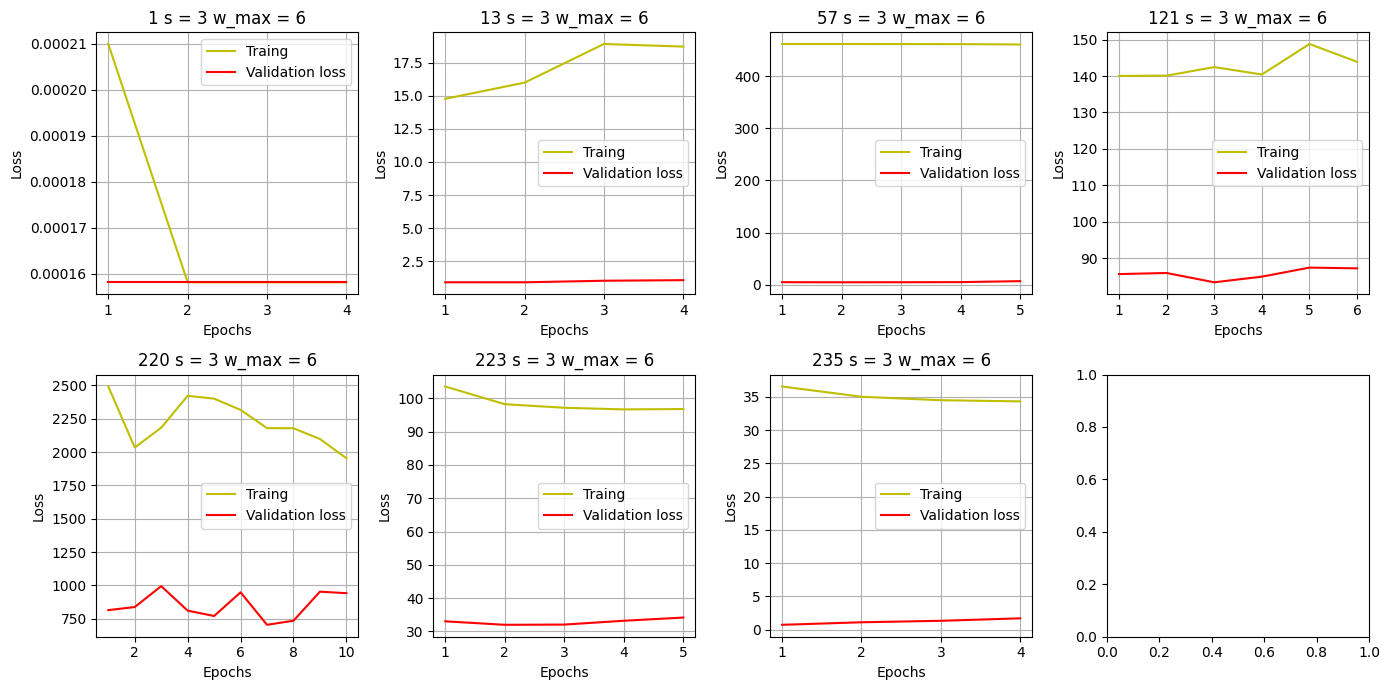

In [11]:
crps_values = []
for country_data in NNet_prediction_list:
    country_crps_list = []
    for entry in country_data[pred_year_string]:
        country_crps_list.append(entry['CRPS'])
    crps_values.append(np.mean(country_crps_list))

mean_crps = np.mean(crps_values)

import numpy as np
import matplotlib.pyplot as plt
s = 3
i = 0 #zeile
j = 0 #spalte
# Erstelle eine Figur mit 1 Zeile und 2 Spalten für die beiden Plots nebeneinander und kleiner
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))

for country_data in NNet_prediction_list:
    loss = country_data[pred_year_string][s-3]['loss']
    val_loss = country_data[pred_year_string][s-3]['val_loss']
    epochs = country_data[pred_year_string][s-3]['epochs']
        
    title_string = str(country_data['country_id']) + ' s = ' + str(s) + ' w_max = ' + str(country_data[pred_year_string][s-3]['w'])

    axes[i][j].plot(epochs, loss, 'y', label='Traing')
    axes[i][j].plot(epochs, val_loss, 'r', label='Validation loss')
    axes[i][j].set_title(title_string)
    axes[i][j].set_xlabel('Epochs')
    axes[i][j].set_ylabel('Loss')
    axes[i][j].legend()
    axes[i][j].grid(True)
    if j == 3:
        i += 1
        j = 0
    else:  
        j += 1

print('Mean CRPS = ' + str(mean_crps) + ' \\'+'\\')
print('Parameters data prep: ' + ' \\'+'\\' + 'wMax='+ str(w_max) + ' validationSize='+str(rel_validation_size) + ' conflictTrapThresh=' + str(mean_fatlities_per_month_threshold) + ' features='+feature_subset+ ' \\'+'\\')
print('Parameters NN: ' + ' \\'+'\\' + 'earlyStoppingPatience=' + str(patience) + ' learningRate='+str(learningRate)+' numberHiddenLayers=3 numberNeurons=neuronshiddenlayer validationSize='+str(rel_validation_size))
print('')

plt.tight_layout()  # Optimiere den Abstand zwischen den Subplots
plt.show()